In [1]:
from collections import defaultdict

import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import jaccard_score
import seaborn as sn
from tabulate import tabulate
from xgboost import XGBClassifier
from ta import add_all_ta_features
from sklearn.feature_selection import RFE
import xgboost as xgb

In [2]:
WINDOW = 16  # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
# (optional, default is '1d')
INTERVAL = '2y'  # use "period" instead of start/end
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
# (optional, default is '1mo')
symbol = 'AAPL'  # Symbol of the desired stock

# one day 16 rows of data


In [3]:
data = yf.download(  # or pdr.get_data_yahoo(...
    tickers=symbol,

    period=INTERVAL,

    interval=FETCH_INTERVAL,

    # group by ticker (to access via data['SPY'])
    # (optional, default is 'column')
    group_by='ticker',

    # adjust all OHLC automatically
    # (optional, default is False)
    # auto_adjust = True,

    # download pre/post regular market hours data
    # (optional, default is False)
    prepost=True,

    # use threads for mass downloading? (True/False/Integer)
    # (optional, default is True)
    threads=False,

    # proxy URL scheme use use when downloading?
    # (optional, default is None)
    proxy=None
)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2019-09-09 04:00:00-04:00,53.347500,53.450000,53.347500,53.450000,53.450000,0
2019-09-09 06:00:00-04:00,53.415000,53.575000,53.415000,53.575000,53.575000,0
2019-09-09 07:00:00-04:00,53.557500,53.575000,53.500000,53.500000,53.500000,0
2019-09-09 08:00:00-04:00,53.520000,53.640000,53.500000,53.625000,53.625000,0
2019-09-09 09:00:00-04:00,53.612500,53.710000,53.612500,53.710000,53.710000,0
...,...,...,...,...,...,...
2021-09-07 08:00:00-04:00,154.700000,155.200000,153.915000,154.960000,154.960000,0
2021-09-07 09:00:00-04:00,154.960000,155.070000,154.850000,154.870000,154.870000,0
2021-09-07 09:30:00-04:00,154.860001,155.955002,154.389999,155.650101,155.650101,23867871


In [4]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)
important_columns = ['open', 'high', 'low', 'close', 'volume']

In [5]:

def calculate_diffs(diff_number, col_name):
    new_col_name = f'{col_name}_{diff_number}'
    data[new_col_name] = data[col_name].diff(diff_number)

In [6]:
# for name in important_columns:
#     for i in range(1, 11):
#         calculate_diffs(i, name)
#
# data.head(10)

In [7]:
data = data.dropna()

<AxesSubplot:xlabel='Datetime'>

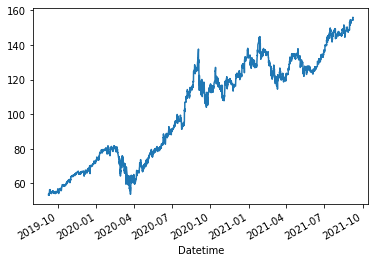

In [8]:
data['close'].plot()

In [9]:
data['close_pct'] = data['close'].pct_change()
data.head()

,open,high,low,close,Adj Close,volume,close_pct
Datetime,,,,,,,
2019-09-09 04:00:00-04:00,53.3475,53.450,53.3475,53.450,53.450,0,NaN
2019-09-09 06:00:00-04:00,53.4150,53.575,53.4150,53.575,53.575,0,0.002339
2019-09-09 07:00:00-04:00,53.5575,53.575,53.5000,53.500,53.500,0,-0.001400
2019-09-09 08:00:00-04:00,53.5200,53.640,53.5000,53.625,53.625,0,0.002336
2019-09-09 09:00:00-04:00,53.6125,53.710,53.6125,53.710,53.710,0,0.001585


In [10]:
data.describe()

,open,high,low,close,Adj Close,volume,close_pct
count,8354.000000,8354.000000,8354.000000,8354.000000,8354.000000,8.354000e+03,8353.000000
mean,103.326399,103.749876,102.802515,103.331485,103.331485,3.863411e+06,0.000145
std,29.870004,30.221913,29.704860,29.867251,29.867251,6.971691e+06,0.005819
min,53.250000,53.287500,50.978220,53.175000,53.175000,0.000000e+00,-0.085960
25%,73.877500,74.158121,73.425000,73.881250,73.881250,0.000000e+00,-0.001621
50%,114.146251,114.600000,113.365000,114.144199,114.144199,0.000000e+00,0.000091
75%,127.967500,128.452670,127.290000,127.940002,127.940002,5.677133e+06,0.001970
max,156.050003,438.440000,156.050003,156.080002,156.080002,9.845401e+07,0.078661


In [11]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    data = add_all_ta_features(
        data, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    # data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()
    # for i in range(1,50):
    #     data[f'close{i}'] = data['close'].shift(i)
    # Remove columns that won't be used as features
    # del (data['Adj Close'])

    return data


In [12]:
data

,open,high,low,close,Adj Close,volume,close_pct
Datetime,,,,,,,
2019-09-09 04:00:00-04:00,53.347500,53.450000,53.347500,53.450000,53.450000,0,NaN
2019-09-09 06:00:00-04:00,53.415000,53.575000,53.415000,53.575000,53.575000,0,0.002339
2019-09-09 07:00:00-04:00,53.557500,53.575000,53.500000,53.500000,53.500000,0,-0.001400
2019-09-09 08:00:00-04:00,53.520000,53.640000,53.500000,53.625000,53.625000,0,0.002336
2019-09-09 09:00:00-04:00,53.612500,53.710000,53.612500,53.710000,53.710000,0,0.001585
...,...,...,...,...,...,...,...
2021-09-07 08:00:00-04:00,154.700000,155.200000,153.915000,154.960000,154.960000,0,0.001745
2021-09-07 09:00:00-04:00,154.960000,155.070000,154.850000,154.870000,154.870000,0,-0.000581
2021-09-07 09:30:00-04:00,154.860001,155.955002,154.389999,155.650101,155.650101,23867871,0.005037


In [13]:
data.columns

Index(['open', 'high', 'low', 'close', 'Adj Close', 'volume', 'close_pct'], dtype='object')

In [14]:
def create_class_column(row, lowest_threshold, higher_threshold):
    if row['close_shift'] - row['close'] > higher_threshold:
        return 1
    if row['close_shift'] - row['close'] < lowest_threshold:
        return -1
    else:
        return 0

In [15]:
data = _get_indicator_data(data)
data['close_shift'] = data.shift(-WINDOW)['close']
moved_price = data['close_shift'].copy()
data

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


,open,high,low,close,Adj Close,volume,close_pct,volume_adi,volume_obv,volume_cmf,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-09-09 04:00:00-04:00,53.347500,53.450000,53.347500,53.450000,53.450000,0,NaN,0.000000e+00,0,0.000000,...,0.000000,53.450000,0.000000,0.000000,0.000000,0.000000,-48.273268,0.000000,0.000000,53.1750
2019-09-09 06:00:00-04:00,53.415000,53.575000,53.415000,53.575000,53.575000,0,0.002339,0.000000e+00,0,0.000000,...,0.000000,53.504003,0.000000,0.000000,0.000000,0.000000,0.233863,0.233590,0.233863,53.3325
2019-09-09 07:00:00-04:00,53.557500,53.575000,53.500000,53.500000,53.500000,0,-0.001400,0.000000e+00,0,0.000000,...,0.000000,53.502281,0.000000,0.000000,0.000000,0.000000,-0.139991,-0.140089,0.093545,53.3500
2019-09-09 08:00:00-04:00,53.520000,53.640000,53.500000,53.625000,53.625000,0,0.002336,0.000000e+00,0,0.000000,...,0.000000,53.554681,0.000000,0.000000,0.000000,0.000000,0.233645,0.233372,0.327409,53.5025
2019-09-09 09:00:00-04:00,53.612500,53.710000,53.612500,53.710000,53.710000,0,0.001585,0.000000e+00,0,0.000000,...,0.000000,53.621276,0.000000,0.000000,0.000000,0.000000,0.158508,0.158383,0.486436,53.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-07 08:00:00-04:00,154.700000,155.200000,153.915000,154.960000,154.960000,0,0.001745,1.785914e+09,606947585,0.140480,...,0.739398,154.268120,0.597252,-49.892636,-29.925861,-19.966775,0.174543,0.174390,189.915809,NaN
2021-09-07 09:00:00-04:00,154.960000,155.070000,154.850000,154.870000,154.870000,0,-0.000581,1.785914e+09,606947585,0.140480,...,0.790987,154.309345,0.633546,-54.209578,-34.782604,-19.426974,-0.058080,-0.058096,189.747428,NaN
2021-09-07 09:30:00-04:00,154.860001,155.955002,154.389999,155.650101,155.650101,23867871,0.005037,1.800482e+09,630815456,0.286344,...,0.901191,154.542867,0.910957,22.340552,-23.357973,45.698525,0.503713,0.502449,191.206924,NaN


In [16]:
moved_price


Datetime
2019-09-09 04:00:00-04:00    53.1750
2019-09-09 06:00:00-04:00    53.3325
2019-09-09 07:00:00-04:00    53.3500
2019-09-09 08:00:00-04:00    53.5025
2019-09-09 09:00:00-04:00    53.5000
                              ...   
2021-09-07 08:00:00-04:00        NaN
2021-09-07 09:00:00-04:00        NaN
2021-09-07 09:30:00-04:00        NaN
2021-09-07 10:30:00-04:00        NaN
2021-09-07 10:59:17-04:00        NaN
Name: close_shift, Length: 8354, dtype: float64

In [17]:
def create_class(df):
    higher_threshold = 1.5
    lowest_threshold = -1.5
    last_values_higher = []
    last_values_lower = []
    df['class_column'] = df.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)), axis=1)
    while True:
        class_counts = df['class_column'].value_counts()
        if abs(class_counts[0] - class_counts[1]) < 15 and abs(class_counts[0] - class_counts[-1]) < 15:
            break

        if len(last_values_higher) == 3:
            last_values_higher.pop(0)
        if len(last_values_lower) == 3:
            last_values_lower.pop(0)

        last_values_higher.append(higher_threshold)
        last_values_lower.append(lowest_threshold)
        if class_counts[0] > class_counts[1]:
            higher_threshold -= 0.01
        if class_counts[0] > class_counts[-1]:
            lowest_threshold += 0.01
        if class_counts[0] < class_counts[1]:
            higher_threshold += 0.01
        if class_counts[0] < class_counts[-1]:
            lowest_threshold -= 0.01

        if higher_threshold in last_values_higher and lowest_threshold in last_values_lower:
            break
        df['class_column'] = df.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)),
                                      axis=1)
    return df


data = create_class(data)

data


,open,high,low,close,Adj Close,volume,close_pct,volume_adi,volume_obv,volume_cmf,...,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift,class_column
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-09-09 04:00:00-04:00,53.347500,53.450000,53.347500,53.450000,53.450000,0,NaN,0.000000e+00,0,0.000000,...,53.450000,0.000000,0.000000,0.000000,0.000000,-48.273268,0.000000,0.000000,53.1750,0
2019-09-09 06:00:00-04:00,53.415000,53.575000,53.415000,53.575000,53.575000,0,0.002339,0.000000e+00,0,0.000000,...,53.504003,0.000000,0.000000,0.000000,0.000000,0.233863,0.233590,0.233863,53.3325,0
2019-09-09 07:00:00-04:00,53.557500,53.575000,53.500000,53.500000,53.500000,0,-0.001400,0.000000e+00,0,0.000000,...,53.502281,0.000000,0.000000,0.000000,0.000000,-0.139991,-0.140089,0.093545,53.3500,0
2019-09-09 08:00:00-04:00,53.520000,53.640000,53.500000,53.625000,53.625000,0,0.002336,0.000000e+00,0,0.000000,...,53.554681,0.000000,0.000000,0.000000,0.000000,0.233645,0.233372,0.327409,53.5025,0
2019-09-09 09:00:00-04:00,53.612500,53.710000,53.612500,53.710000,53.710000,0,0.001585,0.000000e+00,0,0.000000,...,53.621276,0.000000,0.000000,0.000000,0.000000,0.158508,0.158383,0.486436,53.5000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-07 08:00:00-04:00,154.700000,155.200000,153.915000,154.960000,154.960000,0,0.001745,1.785914e+09,606947585,0.140480,...,154.268120,0.597252,-49.892636,-29.925861,-19.966775,0.174543,0.174390,189.915809,NaN,0
2021-09-07 09:00:00-04:00,154.960000,155.070000,154.850000,154.870000,154.870000,0,-0.000581,1.785914e+09,606947585,0.140480,...,154.309345,0.633546,-54.209578,-34.782604,-19.426974,-0.058080,-0.058096,189.747428,NaN,0
2021-09-07 09:30:00-04:00,154.860001,155.955002,154.389999,155.650101,155.650101,23867871,0.005037,1.800482e+09,630815456,0.286344,...,154.542867,0.910957,22.340552,-23.357973,45.698525,0.503713,0.502449,191.206924,NaN,0


In [18]:
filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\train_test\\{symbol}_{INTERVAL}_{WINDOW}_diff_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}_full.csv'
data.to_csv(filename_to_export, index=True)
print(filename_to_export)

C:\Users\exomat\Desktop\repo\magisterka_analiza\data\results\train_test\AAPL_2y_16_diff_07_09_2021 16_59_35_full.csv


In [19]:

# Class divide
data['class_column'].value_counts()

 0    2815
 1    2781
-1    2758
Name: class_column, dtype: int64

In [20]:
# del (data['close'])
# del (data['close_shift'])
data = data.dropna()

In [21]:
data['class_column'].value_counts()


 0    2798
 1    2781
-1    2758
Name: class_column, dtype: int64

In [22]:
def split_dataframe(df, chunk_size=17):
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i * chunk_size:(i + 1) * chunk_size])
    return chunks


def train_model(model, train_x, train_y):
    model.fit(train_x, train_y)

In [23]:
splited_dataframe = split_dataframe(data, 17)
len(splited_dataframe)

491

In [24]:
y = data['class_column']
features = [x for x in data.columns if x not in ['class_column', 'close_shift']]
x = data[features]
scaler = MinMaxScaler()
# x = pd.DataFrame(scaler.fit_transform(x.values), columns=x.columns, index=x.index)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=False)

In [25]:
classifiers = dict()
# classifiers['DecisionTreeClassifier 1'] = DecisionTreeClassifier(max_depth=15, random_state=0, criterion='gini',
#                                                                  splitter='best')
# classifiers['DecisionTreeClassifier 2'] = DecisionTreeClassifier(max_depth=40, random_state=0, criterion='gini',
#                                                                  splitter='best')
# classifiers['DecisionTreeClassifier 3'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='best')
#
#
# classifiers['RandomForestClassifier 1'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,
#                                                                  criterion='gini', n_jobs=-1)
#
# classifiers['RandomForestClassifier 2'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,
#                                                                  criterion='entropy', n_jobs=-1)
#
# classifiers['RandomForestClassifier 3'] = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=0,
#                                                                  criterion='entropy', n_jobs=-1)
#
# classifiers['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100, random_state=0,
#                                                                          criterion='friedman_mse', max_depth=3,
#                                                                          learning_rate=0.1)
#
classifiers['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=1000, random_state=0,
                                                                         criterion='friedman_mse', max_depth=3,
                                                                         learning_rate=0.5)

# classifiers['XGBRFClassifier 1'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1, max_depth=2, n_estimators=1000, eta=0.2 )
# classifiers['XGBRFClassifier 2'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1, max_depth=6, n_estimators=1000, eta=0.3)

# classifiers['XGBClassifier 1'] = xgb.XGBClassifier(nthread=-1, max_depth=3, n_estimators=1000, eta=0.2)
# classifiers['XGBClassifier 2'] = xgb.XGBClassifier(nthread=-1, max_depth=3, n_estimators=1000, eta=0.3)
#
classifiers_boosted = dict()
# # classifiers_boosted['SGradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
# classifiers_boosted['SXGBClassifier 1'] = xgb.XGBClassifier(nthread=-1, max_depth=3, n_estimators=1000, eta=0.2)
# classifiers_boosted['SXGBClassifier 2'] = xgb.XGBClassifier(nthread=-1, max_depth=3, n_estimators=1000, eta=0.3)
# classifiers_boosted['SXGBClassifier 3'] = xgb.XGBClassifier(nthread=-1, max_depth=10, n_estimators=1000, eta=0.2)


In [26]:
data['close'][1701]

80.9625

In [27]:
data['close'][1718]

78.525

In [28]:
(((data['close'][1718] / data['close'][1701])*100)-100)

-3.0106530801296856

In [29]:
def calculate_change(predicted, correct, index):
    change_percentage = (((data['close'][index+WINDOW] / data['close'][index])*100)-100)
    if (predicted==1):
        return change_percentage
    if(predicted==0):
        return 0
    if (predicted== -1 ):
        return 0
        # return -change_percentage

<AxesSubplot:xlabel='Datetime'>

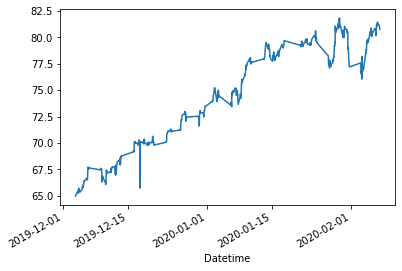

In [30]:
data['close'][1000:1700].plot()

In [31]:
print(len(splited_dataframe))

491


In [32]:
first_row = 99
start = 100
start_data = splited_dataframe[:first_row + 1]
next_data = splited_dataframe[first_row + 1:first_row + 1 + 31]
print(len(next_data))
score = defaultdict(list)
score_sum = defaultdict(list)
score_ind = defaultdict(list)
score_hour = defaultdict(list)
price_now = defaultdict(list)
price_fut = defaultdict(list)
predicted_classes = defaultdict(list)
correct_classes = defaultdict(list)
points = defaultdict(list)
points_train = defaultdict(list)
score_train = defaultdict(list)
step_headers = []
i = 0
print("start")
temp = []

for idx, day in enumerate(next_data):
    first_row += 1
    start_data.append(day)
    data_set = pd.concat(start_data)
    data_set = create_class(data_set)
    y = data_set['class_column']
    features = [x for x in data_set.columns if x not in ['class_column']]
    x = data_set[features]
    x_train = x.iloc[:-34]
    y_train = y.iloc[:-34]
    x_test = x.iloc[-17:]
    y_test = y.iloc[-17:]

    i = i + 1
    predictions_train = dict()
    predictions = dict()
    print("Calculate: ", first_row)
    for k, v in classifiers.items():
        train_model(v, x_train, y_train)

        predicted_class = v.predict(x_test)
        count = 0
        temp=[]
        for idx, el in enumerate(predicted_class):
            if calculate_change(el, y_test[idx], (first_row*17)+idx)!=0:
                count +=1
            score_ind[k].append(calculate_change(el, y_test[idx], (first_row*17)+idx))
            temp.append(calculate_change(el, y_test[idx], (first_row*17)+idx))
            price_now[k].append(data['close'][(first_row*17)+idx])
            price_fut[k].append(data['close'][(first_row*17)+idx+WINDOW])
            score_hour[idx].append(calculate_change(el, y_test[idx], (first_row*17)+idx))
            predicted_classes[k].append(el)
            correct_classes[k].append(y_test[idx])
        if count!=0:
            score[k].append( sum(temp)/count)
        else:
            score[k].append( sum(temp))

        score_sum[k].append(sum(temp))



31
start
Calculate:  100
Calculate:  101
Calculate:  102
Calculate:  103
Calculate:  104
Calculate:  105
Calculate:  106
Calculate:  107
Calculate:  108
Calculate:  109
Calculate:  110
Calculate:  111
Calculate:  112
Calculate:  113
Calculate:  114
Calculate:  115
Calculate:  116
Calculate:  117
Calculate:  118
Calculate:  119
Calculate:  120
Calculate:  121
Calculate:  122
Calculate:  123
Calculate:  124
Calculate:  125
Calculate:  126
Calculate:  127
Calculate:  128
Calculate:  129
Calculate:  130


In [33]:
    # rfe = RFE(classifiers['XGBRFClassifier 1'], 10)
    # fited = rfe.fit(x_train, y_train)
    # names = x.columns
    # columns = []
    # for i in range(len(fited.support_)):
    #     if fited.support_[i]:
    #         columns.append(names[i])
    #
    # print("Columns with predictive power:", columns)
    # columns = columns + ['high', 'low', 'volume', 'open']
    # x_test_cropped = x_test[columns]
    # x_train_cropped = x_train[columns]
    # x_test_cropped = x_test_cropped.loc[:, ~x_test_cropped.columns.duplicated()]
    # x_train_cropped = x_train_cropped.loc[:, ~x_train_cropped.columns.duplicated()]
    # for k, v in classifiers_boosted.items():
    #     print("Calculate: ", k)
    #     train_model(v, x_train, y_train)
    #     predicted_class = v.predict(x_test)
    #     for idx, el in enumerate(predicted_class):
    #         score[k].append(calculate_change(el, y_test[idx], (first_row*17)+idx))





In [34]:
len(score['DecisionTreeClassifier 1'])

0

In [35]:
step_headers.clear()
for a in range(start,start + 31):
    # for b in range (1,18):
    #     step_headers.append(f'<{a},{b}>')
        step_headers.append(f'<{a}>')
len(step_headers)

31

In [36]:
headers = ["Classifier type", "pct_change"]
score_df = pd.DataFrame(score.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type", ] + step_headers
score_df = pd.DataFrame(score.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['pct_change'].tolist(), index=score_df.index, columns=step_headers)
score_df = score_df.drop('pct_change', 1)
f_out: pd.DataFrame = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['sum'] = f_out.sum(axis=1)
f_out['sum'] = f_out['sum'].apply(lambda x: x+100)
headers2 = headers2 + ['sum']
print(tabulate(f_out, headers2, tablefmt="psql"))

filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\simulation\\result_test_ta_all_score_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
f_out.to_csv(filename_to_export, index=False)

+----+------------------------------+------------+-----------+-----------+-----------+---------+-----------+-----------+---------+-----------+-----------+-----------+----------+------------+-----------+---------+---------+---------+-----------+-----------+-----------+------------+---------+-----------+-----------+-------------+-----------+-----------+---------+-----------+-----------+-----------+---------+
|    | Classifier type              |      <100> |     <101> |     <102> |     <103> |   <104> |     <105> |     <106> |   <107> |     <108> |     <109> |     <110> |    <111> |      <112> |     <113> |   <114> |   <115> |   <116> |     <117> |     <118> |     <119> |      <120> |   <121> |     <122> |     <123> |       <124> |     <125> |     <126> |   <127> |     <128> |     <129> |     <130> |     sum |
|----+------------------------------+------------+-----------+-----------+-----------+---------+-----------+-----------+---------+-----------+-----------+-----------+----------+---

In [37]:
step_headers.clear()
for a in range(start,start + 31):
    # for b in range (1,18):
    #     step_headers.append(f'<{a},{b}>')
        step_headers.append(f'<{a}>')

headers = ["Classifier type", "pct_change"]
score_df = pd.DataFrame(score_sum.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type", ] + step_headers
score_df = pd.DataFrame(score_sum.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['pct_change'].tolist(), index=score_df.index, columns=step_headers)
score_df = score_df.drop('pct_change', 1)
f_out: pd.DataFrame = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['sum'] = f_out.sum(axis=1)
f_out['sum'] = f_out['sum'].apply(lambda x: x+100)
headers2 = headers2 + ['sum']
print(tabulate(f_out, headers2, tablefmt="psql"))

filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\simulation\\result_test_ta_all_sum_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
f_out.to_csv(filename_to_export, index=False)


+----+------------------------------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+---------+---------+---------+---------+----------+---------+---------+----------+---------+---------+----------+-----------+---------+---------+---------+---------+---------+---------+---------+
|    | Classifier type              |   <100> |   <101> |   <102> |   <103> |   <104> |   <105> |   <106> |   <107> |    <108> |    <109> |    <110> |    <111> |    <112> |   <113> |   <114> |   <115> |   <116> |    <117> |   <118> |   <119> |    <120> |   <121> |   <122> |    <123> |     <124> |   <125> |   <126> |   <127> |   <128> |   <129> |   <130> |     sum |
|----+------------------------------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+---------+---------+---------+---------+----------+---------+---------+----------+---------+

In [38]:
step_headers.clear()
for a in range(start,start + 31):
    for b in range (1,18):
        step_headers.append(f'<{a},{b}>')

headers = ["Classifier type", "pct_change"]
score_df = pd.DataFrame(score_ind.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type", ] + step_headers
score_df = pd.DataFrame(score_ind.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['pct_change'].tolist(), index=score_df.index, columns=step_headers)
score_df = score_df.drop('pct_change', 1)
f_out: pd.DataFrame = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['sum'] = f_out.sum(axis=1)
f_out['sum'] = f_out['sum'].apply(lambda x: x+100)
headers2 = headers2 + ['sum']
print(tabulate(f_out, headers2, tablefmt="psql"))

filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\simulation\\result_test_ta_all_points_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
f_out.to_csv(filename_to_export, index=False)

+----+------------------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-------

In [39]:
step_headers.clear()
for a in range(start,start + 31):
    for b in range (1,18):
        step_headers.append(f'<{a},{b}>')

headers = ["Classifier type", "pct_change"]
score_df = pd.DataFrame(price_now.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type", ] + step_headers
score_df = pd.DataFrame(price_now.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['pct_change'].tolist(), index=score_df.index, columns=step_headers)
score_df = score_df.drop('pct_change', 1)
f_out: pd.DataFrame = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['sum'] = f_out.sum(axis=1)
f_out['sum'] = f_out['sum'].apply(lambda x: x+100)
headers2 = headers2 + ['sum']
print(tabulate(f_out, headers2, tablefmt="psql"))

filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\simulation\\result_test_ta_all_price_now_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
f_out.to_csv(filename_to_export, index=False)

+----+------------------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-------

In [40]:
step_headers.clear()
for a in range(start,start + 31):
    for b in range (1,18):
        step_headers.append(f'<{a},{b}>')

headers = ["Classifier type", "pct_change"]
score_df = pd.DataFrame(price_fut.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type", ] + step_headers
score_df = pd.DataFrame(price_fut.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['pct_change'].tolist(), index=score_df.index, columns=step_headers)
score_df = score_df.drop('pct_change', 1)
f_out: pd.DataFrame = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['sum'] = f_out.sum(axis=1)
f_out['sum'] = f_out['sum'].apply(lambda x: x+100)
headers2 = headers2 + ['sum']
print(tabulate(f_out, headers2, tablefmt="psql"))

filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\simulation\\result_test_ta_all_price_fut_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
f_out.to_csv(filename_to_export, index=False)

+----+------------------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-------

In [41]:
step_headers.clear()
for a in range(start,start + 31):
    # for b in range (1,18):
        step_headers.append(f'<{a}>')

headers = ["Classifier type", "pct_change"]
score_df = pd.DataFrame(score_hour.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type", ] + step_headers
score_df = pd.DataFrame(score_hour.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['pct_change'].tolist(), index=score_df.index, columns=step_headers)
score_df = score_df.drop('pct_change', 1)
f_out: pd.DataFrame = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['sum'] = f_out.sum(axis=1)
f_out['sum'] = f_out['sum'].apply(lambda x: x+100)
headers2 = headers2 + ['sum']
print(tabulate(f_out, headers2, tablefmt="psql"))

filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\simulation\\result_test_ta_all_score_hour_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
f_out.to_csv(filename_to_export, index=False)

+----+-------------------+-----------+---------+----------+---------+---------+---------+---------+---------+----------+-----------+----------+----------+-----------+---------+---------+---------+---------+----------+---------+-----------+------------+---------+----------+-------------+----------+---------+---------+---------+-----------+----------+---------+---------+
|    |   Classifier type |     <100> |   <101> |    <102> |   <103> |   <104> |   <105> |   <106> |   <107> |    <108> |     <109> |    <110> |    <111> |     <112> |   <113> |   <114> |   <115> |   <116> |    <117> |   <118> |     <119> |      <120> |   <121> |    <122> |       <123> |    <124> |   <125> |   <126> |   <127> |     <128> |    <129> |   <130> |     sum |
|----+-------------------+-----------+---------+----------+---------+---------+---------+---------+---------+----------+-----------+----------+----------+-----------+---------+---------+---------+---------+----------+---------+-----------+------------+----

In [42]:
step_headers.clear()
for a in range(start,start + 31):
    for b in range (1,18):
        step_headers.append(f'<{a},{b}>')

headers = ["Classifier type", "pct_change"]
score_df = pd.DataFrame(predicted_classes.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type", ] + step_headers
score_df = pd.DataFrame(predicted_classes.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['pct_change'].tolist(), index=score_df.index, columns=step_headers)
score_df = score_df.drop('pct_change', 1)
f_out: pd.DataFrame = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['sum'] = f_out.sum(axis=1)
f_out['sum'] = f_out['sum'].apply(lambda x: x+100)
headers2 = headers2 + ['sum']
print(tabulate(f_out, headers2, tablefmt="psql"))

filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\simulation\\result_test_ta_all_predicted_classes_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
f_out.to_csv(filename_to_export, index=False)

+----+------------------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-------

In [43]:
step_headers.clear()
for a in range(start,start + 31):
    for b in range (1,18):
        step_headers.append(f'<{a},{b}>')

headers = ["Classifier type", "pct_change"]
score_df = pd.DataFrame(correct_classes.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type", ] + step_headers
score_df = pd.DataFrame(correct_classes.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['pct_change'].tolist(), index=score_df.index, columns=step_headers)
score_df = score_df.drop('pct_change', 1)
f_out: pd.DataFrame = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['sum'] = f_out.sum(axis=1)
f_out['sum'] = f_out['sum'].apply(lambda x: x+100)
headers2 = headers2 + ['sum']
print(tabulate(f_out, headers2, tablefmt="psql"))

filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\simulation\\result_test_ta_all_correct_classes_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
f_out.to_csv(filename_to_export, index=False)

+----+------------------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-------

In [44]:
cenka = []

', '.join(map(str, data['close'][1700+16:1717+16].tolist()))

'79.25, 79.15, 78.525, 79.56072235107422, 79.9625015258789, 79.80274963378906, 79.91500091552734, 79.96207427978516, 80.31700134277344, 80.38500213623047, 80.2525, 80.15, 80.2375, 80.575, 80.675, 80.645, 80.51'

In [45]:
cenka = []
for i in range (0,17*31):
    cenka.append( data['close'][(99*17) +WINDOW +i])

b = ', '.join(map(str, cenka))

In [46]:
temp = []
for av in correct_classes['XGBRFClassifier 2']:
   temp.extend(av.tolist())

In [47]:
b = ', '.join(map(str, temp))

In [48]:
b

''